# **Atividade -Exercício sobre o material Transfer Learning**

## **Disciplina:** CAP-421-3 Aprendizado Profundo

**Discintes:**

Gabriel Sansigolo

Create 2 different classifications, now exploring the EuroSAT database with Red, Green and Near-Infrared bands (RGNIR):
* instantiate a well-known architecture (e.g. ResNet50) with random weights, train with EuroSAT (RGNIR)
* instantiate the same well-known architecture, but pretrained with ImageNet, and fine-tune with EuroSAT (RGNIR)

Show plots of accuracy and loss along the epochs, for both cases.

### **1 - Importando bibliotecas**

In [ ]:
import os
import torch
from tqdm  import tqdm
import rasterio
from pathlib import Path
import torch.nn as nn
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim

### **2 - RGNIR**

In [ ]:
folders = ["AnnualCrop","Forest","HerbaceousVegetation","Highway","Industrial","Pasture","PermanentCrop","Residential","River","SeaLake"]

os.mkdir('RGNIR/')
os.mkdir('RGNIR/train/')
os.mkdir('RGNIR/validation/')

for folder in folders:
    os.mkdir('RGNIR/train/'+folder)
    os.mkdir('RGNIR/validation/'+folder)

In [ ]:
path_dir = os.path.dirname("")

def create_rgnir(path):

    filenames = os.listdir(path)
    filename_len = len(filenames)

    for i, filename in enumerate(tqdm(filenames)):

        if i < int(filename_len*0.8):
            mode = 'train'
        else:
            mode = 'validation'

        if filename == '_DS_Store':
            continue

        image_src = rasterio.open(os.path.join(path, filename))
        new_image = image_src.read((3,4,8))

        profile = image_src.profile
        profile.update(count=3, driver="PNG")

        with rasterio.open(
            os.path.join('RGNIR/',mode, path.split('/')[1], Path(filename).stem+".png"),
            mode="w",
            **profile,
        ) as new_dataset:
            new_dataset.write(new_image)

In [ ]:
base_path = os.path.dirname("")

path = os.path.join(base_path,'EuroSATallBands/')

annual_crop = create_rgnir(os.path.join(path,"AnnualCrop"))
highway = create_rgnir(os.path.join(path,"Highway"))
pasture = create_rgnir(os.path.join(path,"Pasture"))
river = create_rgnir(os.path.join(path,"River"))
forest = create_rgnir(os.path.join(path,"Forest"))
industrial = create_rgnir(os.path.join(path,"Industrial"))
permanent_crop = create_rgnir(os.path.join(path,"PermanentCrop"))
sea_lake = create_rgnir(os.path.join(path,"SeaLake"))
herbaceous_vegetation = create_rgnir(os.path.join(path,"HerbaceousVegetation"))
residential = create_rgnir(os.path.join(path,"Residential"))

100%|██████████| 3000/3000 [01:36<00:00, 30.97it/s]


### **3 - Função trasformers**

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        normalize
    ]),
}

### **4 - Datasets e dataloaders**

In [ ]:
input_path = "RGNIR/"

In [ ]:
def check_Image(path):
  try:
    im = Image.open(path)
    return True
  except:
    return False

image_datasets = {
    'train':
    datasets.ImageFolder(input_path + 'train', data_transforms['train'], is_valid_file=check_Image),
    'validation':
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'], is_valid_file=check_Image)
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)
}

### **4 - Utiliza GPU (cuda), caso contrário, utiliza CPU**

In [ ]:
device = 'cpu'

### **5 - resnet50 - normal**

In [ ]:
model = models.resnet50(pretrained=False).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 10)).to(device)

c:\Users\Sansigolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sansigolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### **5 - Criterion e optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

### **6 - Treinamento**

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

### **7 - Execução do treinamento - normal**

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 1.6290, acc: 0.4162
validation loss: 1.3053, acc: 0.5368
Epoch 2/20
----------
train loss: 1.3534, acc: 0.5116
validation loss: 1.2777, acc: 0.5408
Epoch 3/20
----------
train loss: 1.2700, acc: 0.5417
validation loss: 1.1788, acc: 0.5696
Epoch 4/20
----------
train loss: 1.2476, acc: 0.5495
validation loss: 1.2042, acc: 0.5560
Epoch 5/20
----------
train loss: 1.2190, acc: 0.5574
validation loss: 1.1404, acc: 0.5871
Epoch 6/20
----------
train loss: 1.1975, acc: 0.5706
validation loss: 1.2693, acc: 0.5444
Epoch 7/20
----------
train loss: 1.1696, acc: 0.5781
validation loss: 1.1675, acc: 0.5832
Epoch 8/20
----------
train loss: 1.1635, acc: 0.5819
validation loss: 1.1360, acc: 0.5933
Epoch 9/20
----------
train loss: 1.1535, acc: 0.5844
validation loss: 1.1928, acc: 0.5761
Epoch 10/20
----------
train loss: 1.1303, acc: 0.5949
validation loss: 1.0734, acc: 0.6161
Epoch 11/20
----------
train loss: 1.1325, acc: 0.5898
validation loss: 1.0625, acc: 0.61

### **8 - Visualização das curvas de treinamento e teste - normal**

In [ ]:
num_epochs = 20

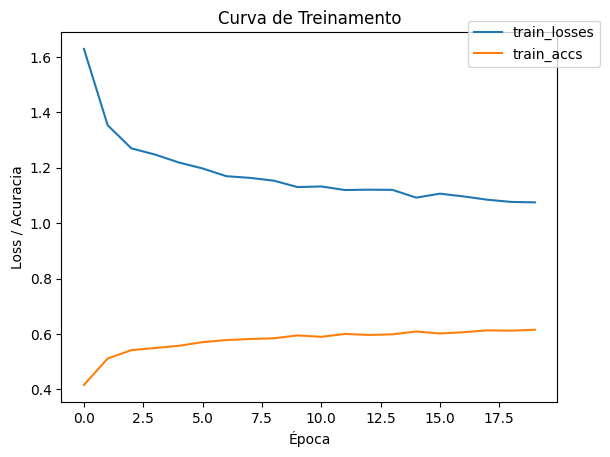

In [ ]:
plt.plot(range(num_epochs), train_loss[:20] , label='train_losses')
plt.plot(range(num_epochs), train_acc[:20], label='train_accs')
plt.title('Curva de Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss / Acuracia')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

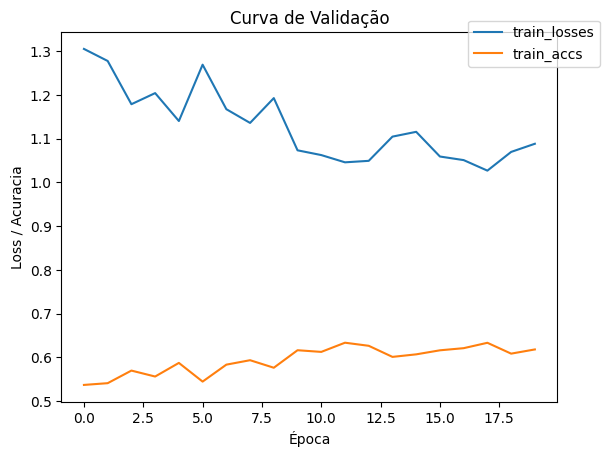

In [ ]:
plt.plot(range(num_epochs), val_loss[:20] , label='train_losses')
plt.plot(range(num_epochs), val_acc[:20], label='train_accs')
plt.title('Curva de Validação')
plt.xlabel('Época')
plt.ylabel('Loss / Acuracia')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

### **8.5 - Salva pesos - normal**

In [ ]:
torch.save(model_trained.state_dict(), 'weights.h5')

### **9 - Validação - normal**

In [ ]:
validation_img_paths = ["train/River/River_1.png",
                        "train/Residential/Residential_1.png",
                        "train/SeaLake/Bombay_000001.png"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[-0.3379, -3.1141, -2.1886,  1.0018,  2.1967, -0.1580, -0.3453, -0.0842,
          1.3839, -6.1068],
        [-0.3985, -2.9574, -1.4564,  0.8135,  2.2156, -0.5779, -1.4851,  2.0806,
         -0.4474, -3.9132],
        [-1.0177, -2.2023,  0.5217, -1.7249, -0.1710, -2.5843, -4.2879, -0.6905,
          2.3281, 10.1210]], grad_fn=<AddmmBackward0>)

In [ ]:
pred_probs = nn.Softmax(pred_logits_tensor).cpu()
pred_probs

Softmax(
  dim=tensor([[-0.3379, -3.1141, -2.1886,  1.0018,  2.1967, -0.1580, -0.3453, -0.0842,
            1.3839, -6.1068],
          [-0.3985, -2.9574, -1.4564,  0.8135,  2.2156, -0.5779, -1.4851,  2.0806,
           -0.4474, -3.9132],
          [-1.0177, -2.2023,  0.5217, -1.7249, -0.1710, -2.5843, -4.2879, -0.6905,
            2.3281, 10.1210]], grad_fn=<AddmmBackward0>)
)

### **10 - resnet50 - pré-treinada**

In [ ]:
pretmodel = models.resnet50(pretrained="IMAGENET1K_V1").to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 10)).to(device)

### **11 - Execução do treinamento - pré-treinada**

In [ ]:
pmodel_trained = train_model(pretmodel, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 12.7544, acc: 0.0007
validation loss: 14.1321, acc: 0.0009
Epoch 2/3
----------
train loss: 12.7731, acc: 0.0006
validation loss: 14.3292, acc: 0.0005
Epoch 3/3
----------
train loss: 12.7489, acc: 0.0005
validation loss: 14.3927, acc: 0.0004


### **12 - Visualização das curvas de treinamento e teste - pré-treinada**

In [ ]:
num_epochs = 3

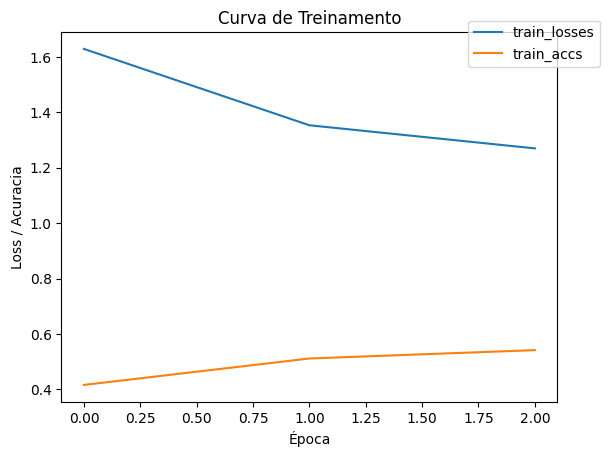

In [ ]:
plt.plot(range(num_epochs), train_loss[:3] , label='train_losses')
plt.plot(range(num_epochs), train_acc[:3], label='train_accs')
plt.title('Curva de Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss / Acuracia')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

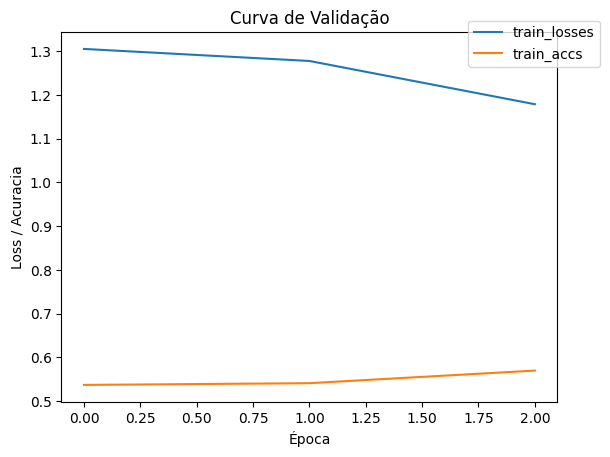

In [ ]:
plt.plot(range(num_epochs), val_loss[:3] , label='train_losses')
plt.plot(range(num_epochs), val_acc[:3], label='train_accs')
plt.title('Curva de Validação')
plt.xlabel('Época')
plt.ylabel('Loss / Acuracia')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

### **12.5 - Salva pesos - pré-treinada**

In [ ]:
torch.save(pmodel_trained.state_dict(), 'weights-pre-treined.h5')

### **13 - Validação - pré-treinada**

In [ ]:
validation_img_paths = ["train/River/River_1.png",
                        "train/Residential/Residential_1.png",
                        "train/SeaLake/Bombay_000001.png"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 0.0272, -0.9226,  0.0950,  0.1259, -0.2709, -0.0060, -0.4868,  0.1690,
         -0.2195, -0.5499],
        [ 0.0157, -0.5184,  0.1189,  0.1778, -0.2566, -0.1138, -0.4979,  0.3074,
         -0.0127, -0.3980],
        [ 0.2275, -0.7395,  0.2603, -0.0031, -0.1404, -0.2608, -0.2846,  0.2013,
         -0.0738, -0.3537]], grad_fn=<AddmmBackward0>)

In [ ]:
pred_probs = nn.Softmax(pred_logits_tensor).cpu()
pred_probs

Softmax(
  dim=tensor([[ 0.0272, -0.9226,  0.0950,  0.1259, -0.2709, -0.0060, -0.4868,  0.1690,
           -0.2195, -0.5499],
          [ 0.0157, -0.5184,  0.1189,  0.1778, -0.2566, -0.1138, -0.4979,  0.3074,
           -0.0127, -0.3980],
          [ 0.2275, -0.7395,  0.2603, -0.0031, -0.1404, -0.2608, -0.2846,  0.2013,
           -0.0738, -0.3537]], grad_fn=<AddmmBackward0>)
)